Run the following cell if data set is not installed

In [ ]:
!gdown --id '1R2pRHPNRBxbPwzyJMHDyMd_xVV6Bcnsp' --output COMP5329S1A2Dataset.zip
!unzip COMP5329S1A2Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COMP5329S1A2Dataset/data/5500.jpg  
  inflating: COMP5329S1A2Dataset/data/5501.jpg  
  inflating: COMP5329S1A2Dataset/data/5502.jpg  
  inflating: COMP5329S1A2Dataset/data/5503.jpg  
  inflating: COMP5329S1A2Dataset/data/5504.jpg  
  inflating: COMP5329S1A2Dataset/data/5505.jpg  
  inflating: COMP5329S1A2Dataset/data/5506.jpg  
  inflating: COMP5329S1A2Dataset/data/5507.jpg  
  inflating: COMP5329S1A2Dataset/data/5508.jpg  
  inflating: COMP5329S1A2Dataset/data/5509.jpg  
  inflating: COMP5329S1A2Dataset/data/551.jpg  
  inflating: COMP5329S1A2Dataset/data/5510.jpg  
  inflating: COMP5329S1A2Dataset/data/5511.jpg  
  inflating: COMP5329S1A2Dataset/data/5512.jpg  
  inflating: COMP5329S1A2Dataset/data/5513.jpg  
  inflating: COMP5329S1A2Dataset/data/5514.jpg  
  inflating: COMP5329S1A2Dataset/data/5515.jpg  
  inflating: COMP5329S1A2Dataset/data/5516.jpg  
  inflating: COMP5329S1A2Dataset/data/5517.jpg  
  inflating: COMP53

In [ ]:
!pip install keras_self_attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=412dc15aaac3553ed4e79a7abb46ab4ca69bda55351576ea3958e27f3bb03904
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


#### How to run the code
The codes are built on the enviroment:
python 3.9
tensorflow 2.6
cudnn 8.2.1
numpy 1.23.5

To run the code, place this file and the folder COMP5329S1A2Dataset (which should contain test.csv, train.csv, the data folder, and glove.6B.300d.txt) in the same directory.

In the first cell, we have listed all the necessary packages. Please install them if you do not already have them.

The model used for the competition is trained using the train_best_model function, and predictions are exported using the make_pred function.

Experiments are all in separate functions. Calling these functions will print each model's summary, their training statistics, and plots of their loss, accuracy, and F1 score.

The runtime without a good GPU is very slow (200 seconds per epoch can extend to 3 hours using Colab's CPU). Colab without a subscription only supports a T4 GPU. Therefore, it is recommended to run the model locally or with a Colab subscription to access a more advanced GPU for faster performance.

In [ ]:
import re
import numpy as np
np.object = object
np.int = int
np.float = float
np.bool = bool
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Embedding, LSTM, Concatenate, Reshape, Multiply, Add, Bidirectional, Activation, GlobalAveragePooling2D, BatchNormalization, ReLU
import tensorflow.keras.backend as K
from keras_self_attention import SeqWeightedAttention
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report
import numpy as np
from io import StringIO
import pandas as pd
import csv

In [ ]:
file_path = 'COMP5329S1A2Dataset/'
with open(file_path+'train.csv') as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    train_df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(file_path+'test.csv') as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    test_df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
train_df

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.
...,...,...,...
29991,29995.jpg,8 1 2,A picture of a truck that is in the middle of ...
29992,29996.jpg,1,A plate topped with a pizza being cut with a s...
29993,29997.jpg,1,A man riding a snowboard on top of snow.
29994,29998.jpg,1,This photo shows people skiing in the mountains.


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
#Turn labels into one hot encoded
y_train = []
for labels in train_df['Labels'].values:
    one_hot_encoded = np.zeros(20)
    for label in labels.split(" "):
        one_hot_encoded[int(label)] = 1
    y_train.append(one_hot_encoded)
y_train = np.array(y_train)
print(y_train.shape)

images = 'COMP5329S1A2Dataset/data/' + train_df['ImageID'].values
captions = train_df['Caption'].values

(29996, 20)


In [ ]:
# Tokenizer initialization with lowercase conversion and custom filters
tokenizer = Tokenizer(lower=True, filters='\n\t')
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1  # +1 is for zero padding.
max_len = len(max((s for s in captions), key=len))

def load_embeddings(path):
    """
    Load word embeddings from a file and store them in a dictionary.

    Parameters:
    - path: The file path to the embeddings file.

    Returns:
    - embeddings_index: A dictionary where the keys are words and the values are their corresponding embedding vectors.
    """
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings = load_embeddings('COMP5329S1A2Dataset/glove.6B.300d.txt')

def filter_embeddings(embeddings, word_index, vocab_size, dim=300):
    """
    Filter and create an embedding matrix based on the given embeddings and word index.

    Parameters:
    - embeddings: A dictionary containing word embeddings (word: vector).
    - word_index: A dictionary mapping words to their indices in the vocabulary.
    - vocab_size: The size of the vocabulary.
    - dim: The dimensionality of the word embeddings (default is 300).

    Returns:
    - embedding_matrix: A numpy array of shape [vocab_size, dim] containing the filtered embeddings.
    """
    embedding_matrix = np.zeros([vocab_size, dim])
    for word, i in word_index.items():
        if i >= vocab_size:
            continue # Skip if index exceeds vocab size
        vector = embeddings.get(word)
        if vector is not None:
            embedding_matrix[i] = vector # Assign vector to matrix
    return embedding_matrix

embedding_size = 300
embedding_matrix = filter_embeddings(embeddings, tokenizer.word_index, vocab_size, embedding_size)

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    """
    Custom F1 Score metric class for TensorFlow Keras.
    """
    def __init__(self, name='f1_score', **kwargs):
        """
        Initialize the F1Score metric with its name and optional keyword arguments.

        Parameters:
        - name: The name of the metric (default is 'f1_score').
        - kwargs: Additional keyword arguments.
        """
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Update the state of the metric with new true labels and predicted labels.

        Parameters:
        - y_true: The ground truth values.
        - y_pred: The predicted values.
        - sample_weight: Optional sample weights.
        """
        y_pred = tf.round(y_pred)
        true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'))
        false_positives = tf.reduce_sum(tf.cast((1-y_true) * y_pred, 'float32'))
        false_negatives = tf.reduce_sum(tf.cast(y_true * (1-y_pred), 'float32'))

        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        """
        Calculate and return the F1 score based on the state variables.
        """
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        """
        Reset the state variables to their initial values.
        """
        self.true_positives.assign(0.)
        self.false_positives.assign(0.)
        self.false_negatives.assign(0.)

In [ ]:
def cnn_basic():
    """
    Build a basic Convolutional Neural Network (CNN) model using Keras.

    Returns:
    - model: A Keras Model object representing the CNN.
    """
    input_img = Input(shape=(224, 224, 3))
    x = Conv2D(128, (3, 3), activation='relu')(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    return Model(input_img, x)

In [ ]:
def lstm_basic():
    """
    Build a basic Long Short-Term Memory (LSTM) model using Keras.

    Returns:
    - model: A Keras Model object representing the LSTM model.
    """
    input_text = Input(shape=(max_len,))
    x = Embedding(vocab_size,
                        embedding_size,
                        weights=[embedding_matrix],
                        trainable=True)(input_text)
    x = LSTM(128)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)
    return Model(input_text, x)

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1):
    """
    Create a residual block with two Conv2D layers and a skip connection.

    Parameters:
    - x: Input tensor.
    - filters: Number of filters for the convolutional layers.
    - kernel_size: Size of the convolutional kernel (default is 3).
    - stride: Stride for the convolutional layers (default is 1).

    Returns:
    - x: Output tensor after applying the residual block.
    """
    shortcut = x
    shortcut = Conv2D(filters, kernel_size, padding='same', strides=stride)(shortcut)

    x = Conv2D(filters, kernel_size, padding='same', strides=stride, activation='relu')(x)
    x = Conv2D(filters, kernel_size, padding='same', strides=stride)(x)
    x = Add()([x, shortcut])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def attach_attention_module(x):
    """
    Attach a simple attention module to the convolutional layer output.

    Parameters:
    - x: Input tensor.

    Returns:
    - x: Output tensor after applying the attention module.
    """
    channel_axis = -1 if K.image_data_format() == 'channels_last' else 1
    channels = x.shape[channel_axis]
    se = GlobalAveragePooling2D()(x)
    se = Reshape((1, 1, channels))(se)

    se = Dense(channels // 16, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([x, se])
    return x

In [ ]:
def res_net():
    """
    Build a ResNet-inspired model with MobileNetV2 as the base model, additional convolutional,
    residual, and attention layers, using Keras.

    Returns:
    - model: A Keras Model object representing the network.
    """
    input_img = Input(shape=(224, 224, 3))

    base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model(input_img)

    x = Conv2D(128, (3, 3), padding='same')(input_img)

    x = MaxPooling2D((2, 2))(x)
    x = residual_block(x, 256)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block(x, 512)
    x = MaxPooling2D((2, 2))(x)

    x = attach_attention_module(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)

    return Model(input_img, x)

In [ ]:
def lstm_att():
    """
    Build an LSTM model with attention mechanism using Keras.

    Returns:
    - model: A Keras Model object representing the LSTM with attention model.
    """
    input_text = Input(shape=(max_len,))
    x = Embedding(vocab_size,
                        embedding_size,
                        weights=[embedding_matrix],
                        trainable=True)(input_text)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = SeqWeightedAttention()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)
    return Model(input_text, x)

In [ ]:
def best_model():
    """
    Build and compile a model that combines a CNN for image data and an LSTM with attention for text data.

    Returns:
    - model: A compiled Keras Model object for multi-label classification.
    """
    image_model = cnn_basic()
    text_model = lstm_att()

    combined_input = Concatenate()([image_model.output, text_model.output])

    x = Dense(128)(combined_input)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)
    output = Dense(20, kernel_regularizer=l2(0.01), activation='sigmoid')(x)  # Multi-label classification

    model = Model(inputs=[image_model.input, text_model.input], outputs=output)
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc', F1Score()])
    return model


In [ ]:
image_data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    """
    Custom data generator for Keras that yields batches of images, captions, and labels.
    """
    def __init__(self, img, cap, lab, batch_size=32, img_size=(224, 224), shuffle=True, augmentation=False, image_data_generator=image_data_generator):
        """
        Initialization of the data generator.

        Parameters:
        - img: List of image file paths.
        - cap: List of corresponding captions.
        - lab: List of corresponding labels.
        - batch_size: Size of the batches (default is 32).
        - img_size: Size to which images are resized (default is (224, 224)).
        - shuffle: Whether to shuffle the data at the beginning of each epoch (default is True).
        - augmentation: Whether to apply data augmentation to images (default is False).
        - image_data_generator: Instance of ImageDataGenerator for augmentation.
        """
        self.image_paths = img
        self.captions = cap
        self.labels = lab
        self.batch_size = batch_size
        self.image_data_generator=image_data_generator
        self.img_size = img_size
        self.shuffle = shuffle
        self.max_len = max_len
        self.augmentation = augmentation
        self.indexes = np.arange(len(self.image_paths))
        if shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data.

        Parameters:
        - index: Index of the batch.

        Returns:
        - A tuple of ([batch_images, batch_texts], batch_labels).
        """
        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        images, texts, batch_labels = self.__data_generation(batch_indexes)
        return [images, texts], batch_labels

    def on_epoch_end(self):
        """
        Shuffle indexes after each epoch if shuffle is set to True.
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_indexes):
        """
        Generates data containing batch_size samples.

        Parameters:
        - batch_indexes: Indexes of the images in the current batch.

        Returns:
        - Tuple of (batch_images, batch_texts, batch_labels).
        """
        batch_images = np.empty((self.batch_size, *self.img_size, 3), dtype='float32')
        batch_texts = np.empty((self.batch_size, self.max_len), dtype='int32')
        batch_labels = np.empty((self.batch_size, 20), dtype='float32')

        for i, idx in enumerate(batch_indexes):
            image = load_img(self.image_paths[idx], target_size=self.img_size)
            image = img_to_array(image)
            if self.augmentation:
                image = self.image_data_generator.random_transform(image)
            image /= 255.0  # Normalize to [0, 1]

            text = self.captions[idx]
            text = tokenizer.texts_to_sequences([text])
            text = pad_sequences(text, maxlen=self.max_len)

            label = self.labels[idx]

            batch_images[i,] = image
            batch_texts[i,] = text[0]  # remove the batch dimension added by texts_to_sequences
            batch_labels[i,] = label

        return batch_images, batch_texts, batch_labels


In [ ]:

image_paths_train, image_paths_val, captions_train, captions_val, labels_train, labels_val = train_test_split(
    images, captions, y_train, test_size=0.1, random_state=42
)
data_gen = DataGenerator(image_paths_train, captions_train, labels_train, shuffle=True, augmentation=False)
val_data_gen = DataGenerator(image_paths_val, captions_val, labels_val, shuffle=False)

In [ ]:
def train_best_model():
    """
    Train the best model using the provided data generator and save the trained model.

    Returns:
    - model: The trained Keras model.
    """
    full_train = DataGenerator(images, captions, y_train, shuffle=True, augmentation=True)#data augmentaiton takes a long time, change this to True if you have good enough gpu
    model = best_model()
    model.summary()

    model.fit(full_train, epochs=8)

    model.save('best_model.h5')
    return model

In [ ]:
def report(model, threshold=0.5):
    """
    Generate a classification report for the model on the validation data for treshold testing.

    Parameters:
    - model: The trained Keras model.
    - threshold: The threshold for classifying predictions as positive (default is 0.5).

    Returns:
    - None
    """
    val_data_gen = DataGenerator(image_paths_val, captions_val, labels_val, batch_size=20, shuffle=False)
    predictions = model.predict(val_data_gen)

    thresholded_predictions = (predictions > threshold).astype(int)

    print(classification_report(np.argmax(thresholded_predictions, axis=1), np.argmax(labels_val, axis=1), zero_division=0))

In [ ]:
def final_pred(model, threshold=0.7):
    """
    Generate final predictions for the test dataset using the trained model and save them to a CSV file.

    Parameters:
    - model: The trained Keras model.
    - threshold: The threshold for classifying predictions as positive (default is 0.7).

    Returns:
    - None
    """
    images_test = 'COMP5329S1A2Dataset/data/' + test_df['ImageID'].values
    captions_test = test_df['Caption'].values
    data_gen = DataGenerator(images_test, captions_test, [[0]*20]*10000, batch_size=20, shuffle=False)
    predictions = model.predict(data_gen)

    indices_predictions = [np.where(row > threshold)[0] for row in predictions]

    # Convert index arrays to space-separated strings (indices are zero-based)
    prediction_strings = [' '.join(map(str, row)) for row in indices_predictions]

    rows = zip(test_df['ImageID'], prediction_strings)
    header = ['ImageID', 'Labels']
    # Write to a CSV file
    with open('predictions.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)  # Write the header
        writer.writerows(rows)  # Write each row to the CSV file

Make the best model

(data augmentation takes a long time, change it to true in train_best_model for slightly better results)

In [ ]:
def make_preds():
    model = train_best_model()
    report(model, 0.7)
    final_pred(model, 0.7)
make_preds()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 128)        3584      ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 245)]                0         []                            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)        0         ['conv2d[0][0]']              
 D)                                                                                         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 9s 44ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.96      1.00      0.98      2214
           2       0.84      0.89      0.86        18
           3       0.39      0.80      0.53        50
           4       0.95      0.70      0.81        30
           5       0.99      0.85      0.92        82
           6       0.65      0.59      0.62        22
           7       0.98      0.71      0.83        70
           8       0.79      0.68      0.73        28
           9       0.91      0.64      0.75        33
          10       0.88      0.71      0.79        31
          11       1.00      0.70      0.83        27
          13       0.96      0.79      0.86        28
          14       0.00      0.00      0.00         0
          15       0.81      0.79      0.80        38
          16       0.92      0.86      0.89        64
          17       0.95  

Test models

In [ ]:
def custom_model(image_model=cnn_basic(), text_model=lstm_basic(), dropout_rate=0.3, activation='sigmoid', regularizer=0.01, lr=0.001):
    image_model = cnn_basic()
    text_model = lstm_basic()

    combined_input = Concatenate()([image_model.output, text_model.output])

    x = Dense(128)(combined_input)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(20, kernel_regularizer=l2(regularizer), activation=activation)(x)  # Multi-label classification

    model = Model(inputs=[image_model.input, text_model.input], outputs=output)
    optimizer = Adam(learning_rate=lr, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc', F1Score()])
    return model


In [ ]:
def lstm_model():
    image_model = cnn_basic()
    text_model = lstm_basic()

    x = Dense(128)(text_model.output)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)
    output = Dense(20, kernel_regularizer=l2(0.01), activation='sigmoid')(x)  # Multi-label classification

    model = Model(inputs=[image_model.input, text_model.input], outputs=output)
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc', F1Score()])
    return model

In [ ]:
def cnn_model():
    image_model = cnn_basic()
    text_model = lstm_basic()

    x = Dense(128)(image_model.output)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)
    output = Dense(20, kernel_regularizer=l2(0.01), activation='sigmoid')(x)  # Multi-label classification

    model = Model(inputs=[image_model.input, text_model.input], outputs=output)
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc', F1Score()])
    return model

Experiments

In [ ]:
import matplotlib.pyplot as plt

Epoch 1/8
843/843 [==============================] - 112s 128ms/step - loss: 0.2496 - acc: 0.7866 - f1_score: 0.6376 - val_loss: 0.1426 - val_acc: 0.8212 - val_f1_score: 0.7443
Epoch 2/8
843/843 [==============================] - 104s 123ms/step - loss: 0.1358 - acc: 0.8285 - f1_score: 0.7587 - val_loss: 0.1197 - val_acc: 0.8343 - val_f1_score: 0.7912
Epoch 3/8
843/843 [==============================] - 102s 121ms/step - loss: 0.1160 - acc: 0.8324 - f1_score: 0.7869 - val_loss: 0.1111 - val_acc: 0.8108 - val_f1_score: 0.7930
Epoch 4/8
843/843 [==============================] - 101s 120ms/step - loss: 0.1044 - acc: 0.8347 - f1_score: 0.8049 - val_loss: 0.1044 - val_acc: 0.8038 - val_f1_score: 0.8089
Epoch 5/8
843/843 [==============================] - 101s 119ms/step - loss: 0.0953 - acc: 0.8393 - f1_score: 0.8206 - val_loss: 0.1001 - val_acc: 0.8300 - val_f1_score: 0.8159
Epoch 6/8
843/843 [==============================] - 101s 120ms/step - loss: 0.0869 - acc: 0.8460 - f1_score: 0.835

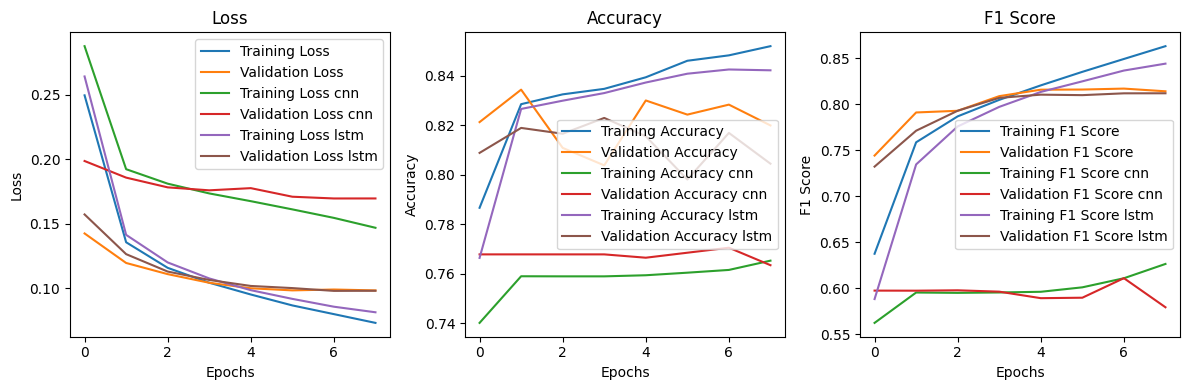

In [ ]:
def basic_model_test():

    model_combined = custom_model()
    history_combined = model_combined.fit(data_gen, validation_data=val_data_gen, epochs=8)
    report(model_combined)
    print(history_combined)
    train_loss = history_combined.history['loss']
    train_accuracy = history_combined.history['acc']
    val_loss = history_combined.history['val_loss']
    val_accuracy = history_combined.history['val_acc']

    train_f1s = history_combined.history['f1_score']
    val_f1s = history_combined.history['val_f1_score']

    model_cnn = cnn_model()
    history_cnn= model_cnn.fit(data_gen, validation_data=val_data_gen, epochs=8)
    report(model_cnn)
    train_loss_cnn = history_cnn.history['loss']
    train_accuracy_cnn = history_cnn.history['acc']
    val_loss_cnn = history_cnn.history['val_loss']
    val_accuracy_cnn = history_cnn.history['val_acc']
    train_f1s_cnn = history_cnn.history['f1_score']
    val_f1s_cnn = history_cnn.history['val_f1_score']


    model_lstm = lstm_model()
    history_lstm = model_lstm.fit(data_gen, validation_data=val_data_gen, epochs=8)
    report(model_lstm)
    train_loss_lstm = history_lstm.history['loss']
    train_accuracy_lstm = history_lstm.history['acc']
    val_loss_lstm = history_lstm.history['val_loss']
    val_accuracy_lstm = history_lstm.history['val_acc']
    train_f1s_lstm = history_lstm.history['f1_score']
    val_f1s_lstm = history_lstm.history['val_f1_score']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.plot(train_loss_cnn, label='Training Loss cnn')
    plt.plot(val_loss_cnn, label='Validation Loss cnn')
    plt.plot(train_loss_lstm, label='Training Loss lstm')
    plt.plot(val_loss_lstm, label='Validation Loss lstm')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.plot(train_accuracy_cnn, label='Training Accuracy cnn')
    plt.plot(val_accuracy_cnn, label='Validation Accuracy cnn')
    plt.plot(train_accuracy_lstm, label='Training Accuracy lstm')
    plt.plot(val_accuracy_lstm, label='Validation Accuracy lstm')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(train_f1s, label='Training F1 Score')
    plt.plot(val_f1s, label='Validation F1 Score')
    plt.plot(train_f1s_cnn, label='Training F1 Score cnn')
    plt.plot(val_f1s_cnn, label='Validation F1 Score cnn')
    plt.plot(train_f1s_lstm, label='Training F1 Score lstm')
    plt.plot(val_f1s_lstm, label='Validation F1 Score lstm')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

basic_model_test()

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/8
843/843 [==============================] - 113s 126ms/step - loss: 0.2553 - acc: 0.7821 - f1_score: 0.6280 - val_loss: 0.1477 - val_acc: 0.8162 - val_f1_score: 0.7503
Epoch 2/8
843/843 [==============================] - 102s 121ms/step - loss: 0.1369 - acc: 0.8286 - f1_score: 0.7584 - val_loss: 0.1210 - val_acc: 0.8185 - val_f1_score: 0.7853
Epoch 3/8
843/843 [==============================] - 103s 122ms/step - loss: 0.1168 - acc: 0.8323 - f1_score: 0.7870 - val_loss: 0.1107 - val_acc: 0.8038 - val_f1_score: 0.7987
Epoch 4/8
843/843 [==============================] - 103s 123ms/step - loss: 0.1047 - acc: 0.8381 - f1_score: 0.8055 - val_loss: 0.1056 - val_acc: 0.8276 - val_f1_score: 0.8044
Epoch 5/8
843/843 [==============================] - 105s 124ms/step - loss: 0.0956 - acc: 0.8419 - f1_score: 0.8211 - val_loss: 0.1036 - val_acc: 0.8538 - val_f1_score: 0.8089
Epoch 6/8
843/843 [==============================] -

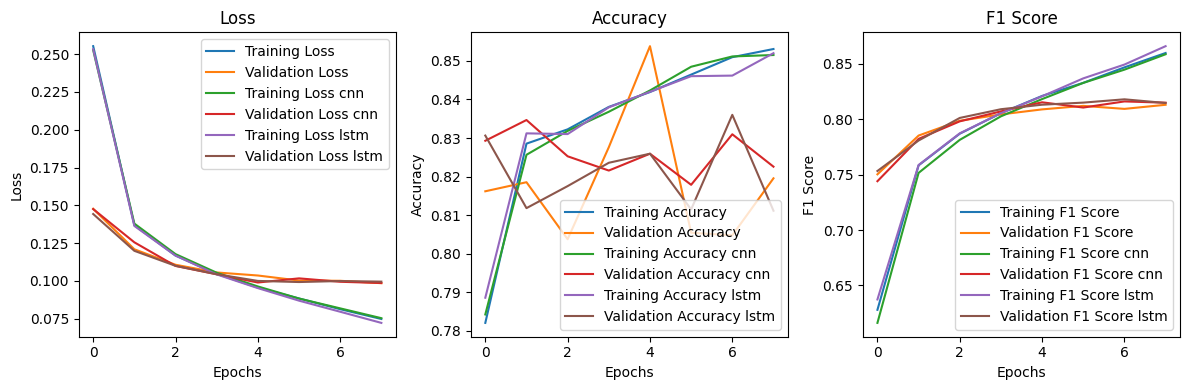

In [ ]:
def advanced_model_test():
    model_combined = custom_model(image_model=res_net(), text_model=lstm_att())
    history_combined = model_combined.fit(data_gen, validation_data=val_data_gen, epochs=8)
    report(model_combined)
    print(history_combined)
    train_loss = history_combined.history['loss']
    train_accuracy = history_combined.history['acc']
    val_loss = history_combined.history['val_loss']
    val_accuracy = history_combined.history['val_acc']
    train_f1s = history_combined.history['f1_score']
    val_f1s = history_combined.history['val_f1_score']

    model_cnn = custom_model(image_model=res_net(), text_model=lstm_basic())
    history_cnn= model_cnn.fit(data_gen, validation_data=val_data_gen, epochs=8)
    report(model_cnn)
    train_loss_cnn = history_cnn.history['loss']
    train_accuracy_cnn = history_cnn.history['acc']
    val_loss_cnn = history_cnn.history['val_loss']
    val_accuracy_cnn = history_cnn.history['val_acc']
    train_f1s_cnn = history_cnn.history['f1_score']
    val_f1s_cnn = history_cnn.history['val_f1_score']


    model_lstm = custom_model(image_model=cnn_basic(), text_model=lstm_att())
    history_lstm = model_lstm.fit(data_gen, validation_data=val_data_gen, epochs=8)
    report(model_lstm)
    train_loss_lstm = history_lstm.history['loss']
    train_accuracy_lstm = history_lstm.history['acc']
    val_loss_lstm = history_lstm.history['val_loss']
    val_accuracy_lstm = history_lstm.history['val_acc']
    train_f1s_lstm = history_lstm.history['f1_score']
    val_f1s_lstm = history_lstm.history['val_f1_score']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.plot(train_loss_cnn, label='Training Loss cnn')
    plt.plot(val_loss_cnn, label='Validation Loss cnn')
    plt.plot(train_loss_lstm, label='Training Loss lstm')
    plt.plot(val_loss_lstm, label='Validation Loss lstm')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.plot(train_accuracy_cnn, label='Training Accuracy cnn')
    plt.plot(val_accuracy_cnn, label='Validation Accuracy cnn')
    plt.plot(train_accuracy_lstm, label='Training Accuracy lstm')
    plt.plot(val_accuracy_lstm, label='Validation Accuracy lstm')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(train_f1s, label='Training F1 Score')
    plt.plot(val_f1s, label='Validation F1 Score')
    plt.plot(train_f1s_cnn, label='Training F1 Score cnn')
    plt.plot(val_f1s_cnn, label='Validation F1 Score cnn')
    plt.plot(train_f1s_lstm, label='Training F1 Score lstm')
    plt.plot(val_f1s_lstm, label='Validation F1 Score lstm')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

advanced_model_test()

parameters testing

In [ ]:
custom_image_gen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)
def parameters_test():
    batch_data_gen = DataGenerator(image_paths_train, captions_train, labels_train, shuffle=True, batch_size=50)
    model_batch = custom_model(image_model=cnn_basic(), text_model=lstm_att())
    history_batch= model_batch.fit(batch_data_gen, validation_data=val_data_gen, epochs=10)
    report(model_batch, 0.9)
    report(model_batch)
    report(model_batch,0.5)
    report(model_batch,0.1)
    train_loss = history_batch.history['loss']
    train_accuracy = history_batch.history['acc']
    val_loss = history_batch.history['val_loss']
    val_accuracy = history_batch.history['val_acc']
    train_f1s = history_batch.history['f1_score']
    val_f1s = history_batch.history['val_f1_score']

    img_data_gen = DataGenerator(image_paths_train, captions_train, labels_train, shuffle=True, image_data_generator=custom_image_gen, augmentation=True)
    model_img = custom_model(image_model=cnn_basic(), text_model=lstm_att())
    history_img= model_img.fit(img_data_gen, validation_data=val_data_gen, epochs=10)
    report(model_img)
    train_loss_cnn = history_img.history['loss']
    train_accuracy_cnn = history_img.history['acc']
    val_loss_cnn = history_img.history['val_loss']
    val_accuracy_cnn = history_img.history['val_acc']
    train_f1s_cnn = history_img.history['f1_score']
    val_f1s_cnn = history_img.history['val_f1_score']


    model_lr = custom_model(image_model=cnn_basic(), text_model=lstm_att(), lr=0.01)
    history_lr = model_lr.fit(data_gen, validation_data=val_data_gen, epochs=10)
    report(model_lr)
    train_loss_lstm = history_lr.history['loss']
    train_accuracy_lstm = history_lr.history['acc']
    val_loss_lstm = history_lr.history['val_loss']
    val_accuracy_lstm = history_lr.history['val_acc']
    train_f1s_lstm = history_lr.history['f1_score']
    val_f1s_lstm = history_lr.history['val_f1_score']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_loss, label='Training Loss batch')
    plt.plot(val_loss, label='Validation Loss batch')
    plt.plot(train_loss_cnn, label='Training Loss img')
    plt.plot(val_loss_cnn, label='Validation Loss img')
    plt.plot(train_loss_lstm, label='Training Loss lr')
    plt.plot(val_loss_lstm, label='Validation Loss lr')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracy, label='Training Accuracy batch')
    plt.plot(val_accuracy, label='Validation Accuracy batch')
    plt.plot(train_accuracy_cnn, label='Training Accuracy img')
    plt.plot(val_accuracy_cnn, label='Validation Accuracy img')
    plt.plot(train_accuracy_lstm, label='Training Accuracy lr')
    plt.plot(val_accuracy_lstm, label='Validation Accuracy lr')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(train_f1s, label='Training F1 Score batch')
    plt.plot(val_f1s, label='Validation F1 Score batch')
    plt.plot(train_f1s_cnn, label='Training F1 Score img')
    plt.plot(val_f1s_cnn, label='Validation F1 Score img')
    plt.plot(train_f1s_lstm, label='Training F1 Score lr')
    plt.plot(val_f1s_lstm, label='Validation F1 Score lr')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

parameters_test()

Epoch 1/10
539/539 [==============================] - 116s 198ms/step - loss: 0.2986 - acc: 0.7780 - f1_score: 0.6183 - val_loss: 0.1629 - val_acc: 0.8320 - val_f1_score: 0.7425
Epoch 2/10
539/539 [==============================] - 98s 181ms/step - loss: 0.1497 - acc: 0.8293 - f1_score: 0.7442 - val_loss: 0.1345 - val_acc: 0.8112 - val_f1_score: 0.7746
Epoch 3/10
539/539 [==============================] - 98s 182ms/step - loss: 0.1281 - acc: 0.8332 - f1_score: 0.7749 - val_loss: 0.1238 - val_acc: 0.8222 - val_f1_score: 0.7936
Epoch 4/10
539/539 [==============================] - 102s 189ms/step - loss: 0.1141 - acc: 0.8393 - f1_score: 0.7983 - val_loss: 0.1120 - val_acc: 0.8296 - val_f1_score: 0.8033
Epoch 5/10
539/539 [==============================] - 98s 181ms/step - loss: 0.1039 - acc: 0.8399 - f1_score: 0.8149 - val_loss: 0.1084 - val_acc: 0.8266 - val_f1_score: 0.8070
Epoch 6/10
539/539 [==============================] - 98s 181ms/step - loss: 0.0949 - acc: 0.8475 - f1_score: 0.8